# Introduction

# Imports

In [33]:
import os, gc
import torch

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None)

# Initial setup

## GPU

In [34]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Pytorch lightning and forecasting

In [35]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer
from pytorch_forecasting.metrics import RMSE, MultiLoss

# Load input

In [36]:
from dataclasses import dataclass

@dataclass
class args:
    result_folder = '../scratch/total_age_group/'
    figPath = os.path.join(result_folder, 'figures')
    checkpoint_folder = os.path.join(result_folder, 'checkpoints')
    input_filePath = '../2022_May_age_groups/Top_100.csv'

    configPath = '../configurations/age_groups.json'

    # Path/URL of the checkpoint from which training is resumed
    ckpt_model_path = None # os.path.join(checkpoint_folder, 'latest-epoch=0.ckpt')
    
    # set this to false when submitting batch script, otherwise it prints a lot of lines
    show_progress_bar = True

    static_feature_index = 0

In [37]:
total_data = pd.read_csv(args.input_filePath)
print(total_data.shape)
total_data.head()

(80900, 14)


,FIPS,Date,VaccinationFull,AGE019,AGE2029,AGE3039,AGE4049,AGE5064,AGE6579,AGE80PLUS,Cases,TimeFromStart,SinWeekly,CosWeekly
0,2261,2020-12-13,0.0,0.208,0.111,0.193,0.123,0.248,0.085,0.031,2.0,288,-0.782,0.623
1,4013,2020-12-13,0.0,0.212,0.140,0.189,0.152,0.177,0.075,0.054,3367.0,288,-0.782,0.623
2,4019,2020-12-13,0.0,0.201,0.163,0.147,0.122,0.181,0.111,0.077,795.0,288,-0.782,0.623
3,6001,2020-12-13,0.0,0.173,0.124,0.246,0.170,0.176,0.062,0.048,563.0,288,-0.782,0.623
4,6013,2020-12-13,0.0,0.198,0.115,0.172,0.171,0.210,0.078,0.057,429.0,288,-0.782,0.623


# Config

In [38]:
import json
import sys
sys.path.append( '..' )
from Class.Parameters import Parameters
from script.utils import *

with open(args.configPath, 'r') as input_file:
  config = json.load(input_file)

parameters = Parameters(config, **config)

print(f'Static features {parameters.data.static_features}. \
  Choosing feature {parameters.data.static_features[args.static_feature_index]}.')
# here we are going to train by one static feature at a time
parameters.data.static_features = [parameters.data.static_features[args.static_feature_index]]

Static features ['AGE019', 'AGE2029', 'AGE3039', 'AGE4049', 'AGE5064', 'AGE6579', 'AGE80PLUS'].   Choosing feature AGE019.


In [39]:
targets = parameters.data.targets
time_idx = parameters.data.time_idx
tft_params = parameters.model_parameters

max_prediction_length = tft_params.target_sequence_length
max_encoder_length = tft_params.input_sequence_length

# Seed

In [40]:
import random

def seed_torch(seed=7):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    pl.seed_everything(seed)

seed_torch(tft_params.seed)

Global seed set to 7


# Processing

In [41]:
total_data['Date'] = pd.to_datetime(total_data['Date'].values) 
total_data['FIPS'] = total_data['FIPS'].astype(str)
print(f"There are {total_data['FIPS'].nunique()} unique counties in the dataset.")

There are 100 unique counties in the dataset.


## Adapt input to encoder length
Input data length needs to be a multiple of encoder length to created batch data loaders.

In [42]:
train_start = parameters.data.split.train_start
total_data = total_data[total_data['Date']>=train_start]
total_data[time_idx] = (total_data["Date"] - train_start).apply(lambda x: x.days)

## Train validation test split and scaling

In [43]:
train_data, validation_data, test_data = train_validation_test_split(
    total_data, parameters
)

Train samples 64000, validation samples 2800, test samples 2800
640 days of training, 15 days of validation data, 15 days of test data.


In [44]:
train_scaled, validation_scaled, test_scaled, target_scaler = scale_data(
    train_data, validation_data, test_data, parameters
)

Scaling static and dynamic input features: ['AGE019', 'VaccinationFull']
Scaling targets ['Cases']


## Create dataset and dataloaders

In [45]:
def prepare_data(data: pd.DataFrame, pm: Parameters, train=False):

  data_timeseries = TimeSeriesDataSet(
    data,
    time_idx= time_idx,
    target=targets,
    group_ids=pm.data.id, 
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals=pm.data.static_features,
    # static_categoricals=['FIPS'],
    time_varying_known_reals = pm.data.time_varying_known_features,
    time_varying_unknown_reals = pm.data.time_varying_unknown_features,
    target_normalizer = MultiNormalizer(
      [GroupNormalizer(groups=pm.data.id) for _ in range(len(targets))]
    )
  )

  if train:
    dataloader = data_timeseries.to_dataloader(train=True, batch_size=tft_params.batch_size)
  else:
    dataloader = data_timeseries.to_dataloader(train=False, batch_size=tft_params.batch_size*8)

  return data_timeseries, dataloader

In [46]:
train_timeseries, train_dataloader = prepare_data(train_scaled, parameters, train=True)
_, validation_dataloader = prepare_data(validation_scaled, parameters)
_, test_dataloader = prepare_data(test_scaled, parameters)

del validation_scaled, test_scaled
gc.collect()

24

# Training

## Trainer and logger

In [47]:
import tensorflow as tf
# click this and locate the lightning_logs folder path and select that folder. 
# this will load tensorbaord visualization
import tensorboard as tb
from pytorch_lightning.loggers import TensorBoardLogger
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile


In [48]:
# notice that the early stopping patience is very high (60) for the old
# TF1 notebook. To reproduce that, replace patience=60
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=tft_params.early_stopping_patience
    , verbose=True, mode="min"
)

# https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.callbacks.ModelCheckpoint.html
best_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=args.checkpoint_folder, monitor="val_loss", filename="best-{epoch}"
)
latest_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=args.checkpoint_folder, every_n_epochs=1, filename="latest-{epoch}"
)

logger = TensorBoardLogger(args.result_folder)  # logging results to a tensorboard
# https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-class-api
trainer = pl.Trainer(
    max_epochs = tft_params.epochs,
    accelerator = 'auto',
    enable_model_summary=True,
    gradient_clip_val = tft_params.clipnorm,
    callbacks = [early_stop_callback, best_checkpoint, latest_checkpoint],
    enable_progress_bar = args.show_progress_bar,
    check_val_every_n_epoch = 1,
    logger=logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Model

In [49]:
# https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer.html
tft = TemporalFusionTransformer.from_dataset(
    train_timeseries,
    learning_rate= tft_params.learning_rate,
    hidden_size= tft_params.hidden_layer_size,
    attention_head_size=tft_params.attention_head_size,
    dropout=tft_params.dropout_rate,
    loss=MultiLoss([RMSE(reduction='mean') for _ in targets]), # RMSE(reduction='sqrt-mean')
    optimizer='adam',
    log_interval=1,
    # reduce_on_plateau_patience=2
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 16.5k


The training speed is here mostly determined by overhead and choosing a larger `batch_size` or `hidden_size` (i.e. network size) does not slow training linearly making training on large datasets feasible. During training, we can monitor the tensorboard which can be spun up with `tensorboard --logdir=lightning_logs`. For example, we can monitor examples predictions on the training and validation set.

In [50]:
from datetime import datetime

gc.collect()

start = datetime.now()
print(f'\n----Training started at {start}----\n')

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=validation_dataloader,
    ckpt_path=args.ckpt_model_path
)
end = datetime.now()
print(f'\n----Training ended at {end}, elapsed time {end-start}')
print(f'Best model by validation loss saved at {trainer.checkpoint_callback.best_model_path}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 528   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 


----Training started at 2023-02-10 00:38:32.238381----



Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.668


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0. New best score: 0.629


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0. New best score: 0.604


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0. New best score: 0.590


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.590. Signaling Trainer to stop.



----Training ended at 2023-02-10 00:46:41.290901, elapsed time 0:08:09.052520
Best model by validation loss saved at C:\Softwares\gpce-covid\TFT-pytorch\scratch\total_age_group\checkpoints\best-epoch=6.ckpt


# Prediction Processor and PlotResults

In [51]:
from Class.PredictionProcessor import PredictionProcessor

processor = PredictionProcessor(
    time_idx, parameters.data.id[0], max_prediction_length, targets, 
    train_start, max_encoder_length
)

In [52]:
from Class.Plotter import *

plotter = PlotResults(args.figPath, targets, show=args.show_progress_bar)

Creating folder ../scratch/total_age_group/figures


# Evaluate - best model
Best model checkpointed by validation loss.

In [53]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(f'Loading best model from {best_model_path}')
tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

Loading best model from C:\Softwares\gpce-covid\TFT-pytorch\scratch\total_age_group\checkpoints\best-epoch=6.ckpt


## Train results

### Average


---Training prediction--



Predict:   0%|          | 0/957 [00:00<?, ? batches/s]


Train raw prediction shapes

prediction list of length 1 torch.Size([61248, 15, 1])
encoder_attention torch.Size([61248, 15, 4, 13])
decoder_attention torch.Size([61248, 15, 4, 15])
static_variables torch.Size([61248, 1, 1])
encoder_variables torch.Size([61248, 13, 1, 3])
decoder_variables torch.Size([61248, 15, 1, 1])
decoder_lengths torch.Size([61248])
encoder_lengths torch.Size([61248])

---Training results--

Target Cases, MAE 126.84, RMSE 300.79, RMSLE 1.7327, SMAPE 0.6269. NNSE 0.82116.



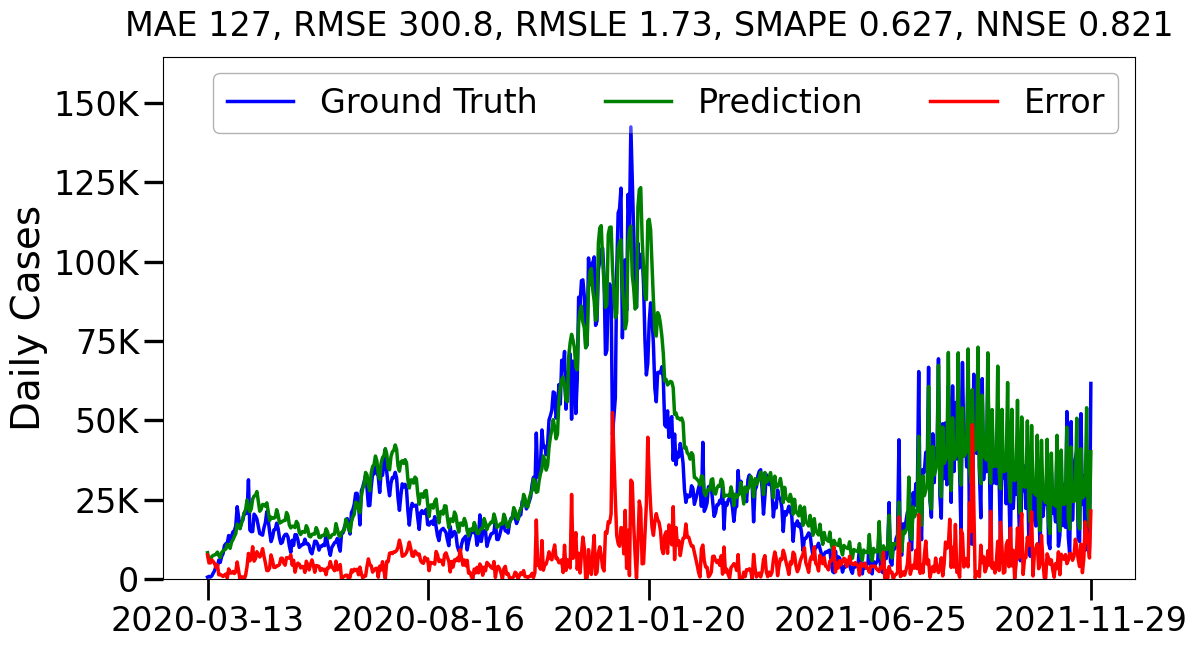

3716

In [54]:
print('\n---Training prediction--\n')
train_predictions, train_index = tft.predict(
    train_dataloader, mode="raw", return_index=True, show_progress_bar=args.show_progress_bar
)

print('\n---Training results--\n')
train_predictions = upscale_prediction(targets, train_predictions, target_scaler, max_prediction_length)
train_result_merged = processor.align_result_with_dataset(train_data, train_predictions, train_index)

show_result(train_result_merged, targets)
plotter.summed_plot(train_result_merged, type='Train_error', plot_error=True)
gc.collect()

## Validation results


---Validation results--



Predict:   0%|          | 0/1 [00:00<?, ? batches/s]

Target Cases, MAE 256.49, RMSE 490.93, RMSLE 2.6226, SMAPE 0.83589. NNSE 0.62187.



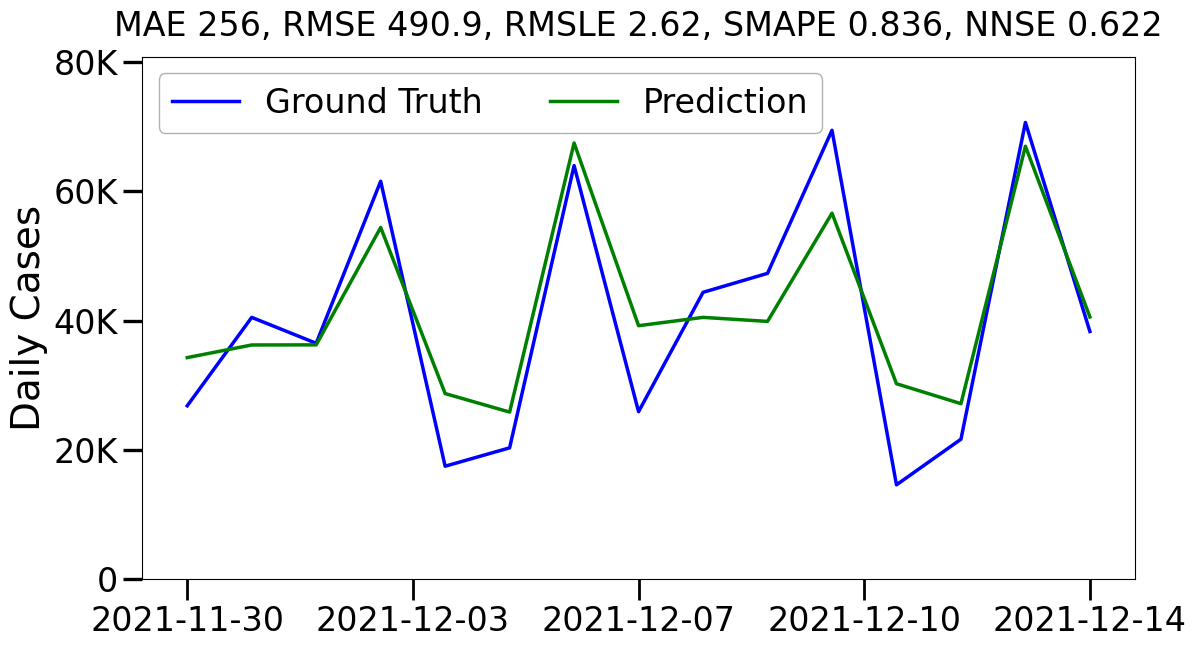

3259

In [55]:
print(f'\n---Validation results--\n')

validation_raw_predictions, validation_index = tft.predict(
    validation_dataloader, return_index=True, show_progress_bar=args.show_progress_bar
)
validation_predictions = upscale_prediction(targets, validation_raw_predictions, target_scaler, max_prediction_length)

validation_result_merged = processor.align_result_with_dataset(validation_data, validation_predictions, validation_index)
show_result(validation_result_merged, targets)
plotter.summed_plot(validation_result_merged, type='Validation')
gc.collect()

## Test results


---Test results--



Predict:   0%|          | 0/1 [00:00<?, ? batches/s]

Target Cases, MAE 613.53, RMSE 1240.4, RMSLE 2.6268, SMAPE 0.83796. NNSE 0.58722.



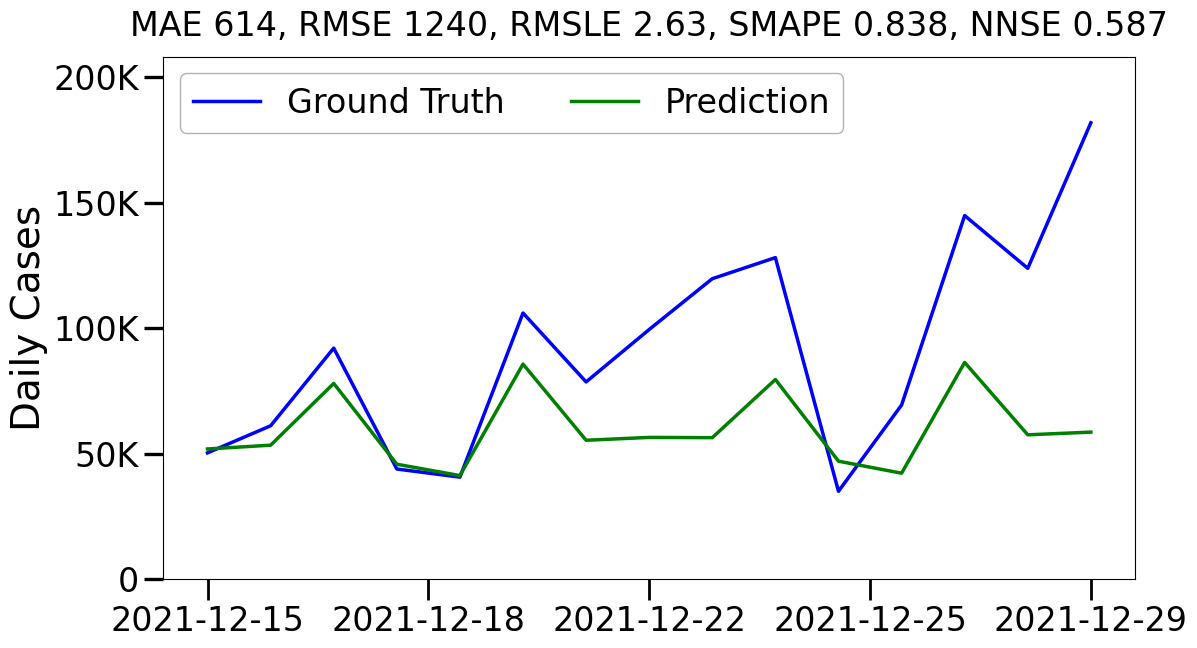

3259

In [56]:
print(f'\n---Test results--\n')

test_raw_predictions, test_index = tft.predict(
    test_dataloader, mode="raw", return_index=True, show_progress_bar=args.show_progress_bar
)
test_predictions = upscale_prediction(targets, test_raw_predictions['prediction'], target_scaler, max_prediction_length)

test_result_merged = processor.align_result_with_dataset(total_data, test_predictions, test_index)
show_result(test_result_merged, targets)
plotter.summed_plot(test_result_merged, 'Test')
gc.collect()

## Dump results

In [57]:
train_result_merged['split'] = 'train'
validation_result_merged['split'] = 'validation'
test_result_merged['split'] = 'test'
df = pd.concat([train_result_merged, validation_result_merged, test_result_merged])
df.to_csv(os.path.join(plotter.figPath, 'predictions.csv'), index=False)

df.head()

,FIPS,TimeFromStart,Predicted_Cases,Cases,Date,split
0,11001,13,47.0,0.0,2020-03-13,train
1,12011,13,76.0,9.0,2020-03-13,train
2,12031,13,33.0,0.0,2020-03-13,train
3,12057,13,45.0,0.0,2020-03-13,train
4,12071,13,24.0,0.0,2020-03-13,train


In [58]:
del train_predictions, validation_predictions, test_predictions
gc.collect()

0

# End

In [59]:
print(f'Ended at {datetime.now()}. Elapsed time {datetime.now() - start}')

Ended at 2023-02-10 00:47:15.287361. Elapsed time 0:08:43.048980
